In [2]:
!pip install tabpfn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Sirve para imputar los valores a través del método KNN
from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import catboost
import optuna


from optuna.samplers import TPESampler
from sklearn.metrics import accuracy_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

# Visualization Data

In [5]:
df_train.info()
print('-'*50)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
-

In [ ]:
df_train.hist(bins=70, figsize=(30,30))

In [ ]:
set(df_train['Stage_fear'])

In [ ]:
set(df_train['Drained_after_socializing'])

In [ ]:
set(df_train['Personality'])

# Creación de Pipeline

In [ ]:
# Definir las columnsa númericas y categóricas
numerical_features = ['id','Time_spent_Alone','Social_event_attendance','Going_outside','Friends_circle_size','Post_frequency']

In [4]:
df_visualization = df_train.copy()

In [5]:
df_visualization['Time_spent_Alone'] = df_visualization['Time_spent_Alone'].fillna(-1)
df_visualization['Stage_fear'] = df_visualization['Stage_fear'].fillna('What')
df_visualization['Social_event_attendance'] = df_visualization['Social_event_attendance'].fillna(-1)
df_visualization['Going_outside'] = df_visualization['Going_outside'].fillna(-1)
df_visualization['Drained_after_socializing'] = df_visualization['Drained_after_socializing'].fillna('What')
df_visualization['Friends_circle_size'] = df_visualization['Friends_circle_size'].fillna(-1)
df_visualization['Post_frequency'] = df_visualization['Post_frequency'].fillna(-1)

In [ ]:
df_visualization.info()

In [6]:
le = LabelEncoder()
df_visualization['Stage_fear'] = le.fit_transform(df_visualization['Stage_fear'])
df_visualization['Drained_after_socializing'] = le.fit_transform(df_visualization['Drained_after_socializing'])
df_visualization['Personality'] = le.fit_transform(df_visualization['Personality'])

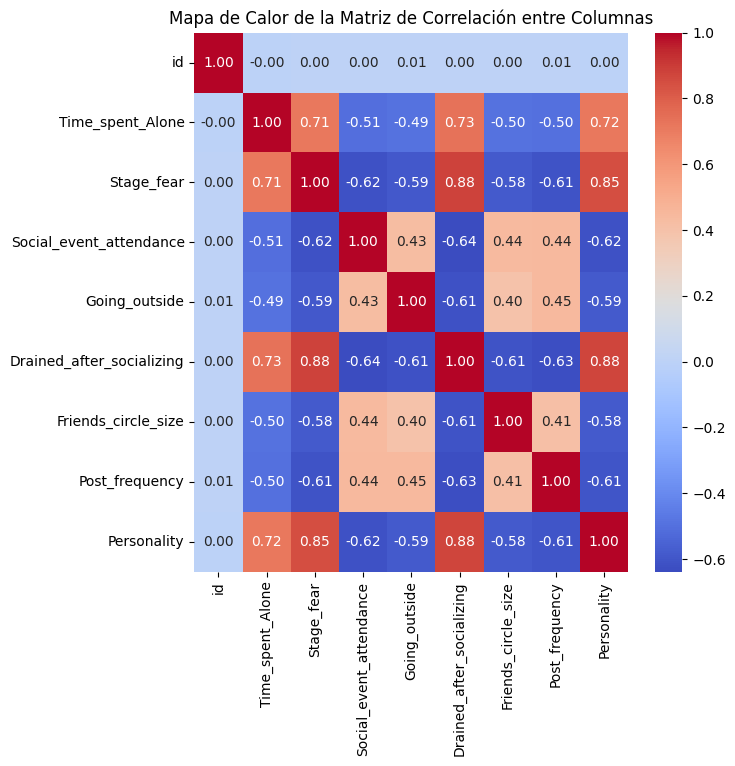

In [7]:
# Calcular la matriz de correlación
correlation_matrix = df_visualization.corr(numeric_only=True)

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(7, 7))  # Ajusta el tamaño de la figura según necesites
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor de la Matriz de Correlación entre Columnas')
plt.show()

# Data Cleaning

## 1 with random values and median values

## 1.1 with random values in categorical data

with random values to categorical data

In [8]:
df_train_simple = df_train.copy()

In [9]:
options = ['Yes', 'No']

In [10]:
index_nan = df_train_simple[df_train_simple['Stage_fear'].isnull()].index
print(index_nan)

Index([   13,    17,    22,    26,    27,    59,    64,    65,    87,    89,
       ...
       18435, 18441, 18458, 18485, 18488, 18498, 18504, 18507, 18518, 18520],
      dtype='int64', length=1893)


In [11]:
# Generar un array de elecciones aleatorias ('yes' o 'no') del mismo tamaño que los NaN
random_select = np.random.choice(options, size=len(index_nan))

# Asignar las elecciones aleatorias a los valores nulos
df_train_simple.loc[index_nan, 'Stage_fear'] = random_select

print(df_train_simple['Stage_fear'].isnull().sum())
print(df_train_simple['Stage_fear'])

0
0         No
1         No
2        Yes
3         No
4         No
        ... 
18519     No
18520     No
18521    Yes
18522    Yes
18523     No
Name: Stage_fear, Length: 18524, dtype: object


In [12]:
index_nan_ = df_train_simple[df_train_simple['Drained_after_socializing'].isnull()].index
print(index_nan_ )

Index([    2,     8,    34,    43,    68,    71,    77,   105,   157,   158,
       ...
       18301, 18310, 18313, 18324, 18329, 18337, 18393, 18449, 18493, 18497],
      dtype='int64', length=1149)


In [13]:
# Generar un array de elecciones aleatorias ('yes' o 'no') del mismo tamaño que los NaN
random_select = np.random.choice(options, size=len(index_nan_))

# Asignar las elecciones aleatorias a los valores nulos
df_train_simple.loc[index_nan_, 'Drained_after_socializing'] = random_select

print(df_train_simple['Drained_after_socializing'].isnull().sum())
print(df_train_simple['Drained_after_socializing'])

0
0         No
1         No
2         No
3         No
4         No
        ... 
18519     No
18520     No
18521    Yes
18522    Yes
18523     No
Name: Drained_after_socializing, Length: 18524, dtype: object


Todos los datos númericos son discretos, así que voy a mirar el método describe, aunque creería que toca llenar los datos con la mediana, porque tienen distribuciones entre los mismos datos


## 1.2 with median value to numerical values

In [14]:
df_train_simple.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [15]:
df_train_simple.fillna({'Time_spent_Alone': df_train_simple['Time_spent_Alone'].median()}, inplace=True)
print(df_train_simple['Time_spent_Alone'].isnull().sum())

0


In [16]:
df_train_simple.fillna({'Social_event_attendance': df_train_simple['Social_event_attendance'].median()}, inplace=True)
print(df_train_simple['Social_event_attendance'].isnull().sum())

0


In [17]:
df_train_simple.fillna({'Going_outside': df_train_simple['Going_outside'].median()}, inplace=True)
print(df_train_simple['Going_outside'].isnull().sum())

0


In [18]:
df_train_simple.fillna({'Friends_circle_size': df_train_simple['Friends_circle_size'].median()}, inplace=True)
print(df_train_simple['Friends_circle_size'].isnull().sum())

0


In [19]:
df_train_simple.fillna({'Post_frequency': df_train_simple['Post_frequency'].median()}, inplace=True)
print(df_train_simple['Post_frequency'].isnull().sum())

0


In [19]:
df_train_simple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           18524 non-null  float64
 2   Stage_fear                 18524 non-null  object 
 3   Social_event_attendance    18524 non-null  float64
 4   Going_outside              18524 non-null  float64
 5   Drained_after_socializing  18524 non-null  object 
 6   Friends_circle_size        18524 non-null  float64
 7   Post_frequency             18524 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [20]:
# Unicamente para poder visualizar las respectivas correlaciones entre las respectivas columnas
#le = LabelEncoder()
#df_train_simple['Stage_fear'] = le.fit_transform(df_train_simple['Stage_fear'])
#df_train_simple['Drained_after_socializing'] = le.fit_transform(df_train_simple['Drained_after_socializing'])
#df_train_simple['Personality'] = le.fit_transform(df_train_simple['Personality'])

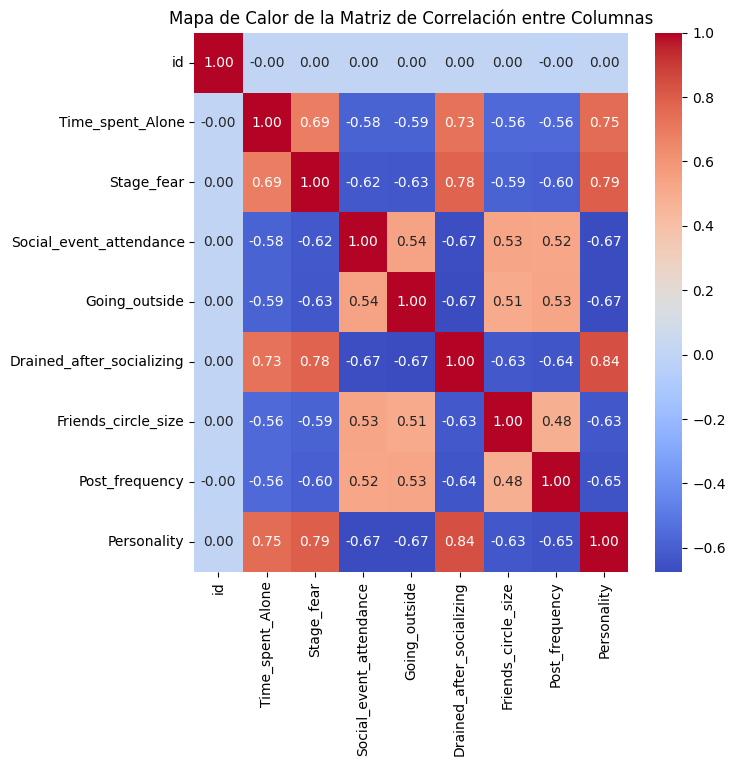

In [21]:
# Calcular la matriz de correlación
correlation_matrix = df_train_simple.corr(numeric_only=True)

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(7, 7))  # Ajusta el tamaño de la figura según necesites
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor de la Matriz de Correlación entre Columnas')
plt.show()

## 2 with KNN Imputer*

In [22]:
df_train_knn = df_train.copy()

In [23]:
label_encoders = {}

# Aplica LabelEncoder a cada columna y guarda el encoder
for column in ['Stage_fear', 'Drained_after_socializing', 'Personality']:
    le = LabelEncoder()
    df_train_knn[column] = le.fit_transform(df_train_knn[column])
    label_encoders[column] = le

# Ahora, para ver la asignación de números a cada categoría:
print("Asignación para 'Stage_fear':")
for i, category in enumerate(label_encoders['Stage_fear'].classes_):
    print(f"'{category}': {i}")

print("\nAsignación para 'Drained_after_socializing':")
for i, category in enumerate(label_encoders['Drained_after_socializing'].classes_):
    print(f"'{category}': {i}")

print("\nAsignación para 'Personality':")
for i, category in enumerate(label_encoders['Personality'].classes_):
    print(f"'{category}': {i}")

Asignación para 'Stage_fear':
'No': 0
'Yes': 1
'nan': 2

Asignación para 'Drained_after_socializing':
'No': 0
'Yes': 1
'nan': 2

Asignación para 'Personality':
'Extrovert': 0
'Introvert': 1


In [24]:
df_train_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 18524 non-null  int64  
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  18524 non-null  int64  
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 1.3 MB


In [25]:
df_train_knn['Stage_fear'] = df_train_knn['Stage_fear'].replace(2, np.nan)

In [26]:
df_train_knn['Drained_after_socializing'] = df_train_knn['Drained_after_socializing'].replace(2, np.nan)

In [27]:
df_train_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  float64
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  float64
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.3 MB


In [28]:
columns = ['id']
train_df_encoded = df_train_knn.drop(columns, axis=1)

In [29]:
imputer = KNNImputer()

In [30]:
without_nan = imputer.fit_transform(train_df_encoded)
without_nan

array([[ 0. ,  0. ,  6. , ..., 15. ,  5. ,  0. ],
       [ 1. ,  0. ,  7. , ..., 10. ,  8. ,  0. ],
       [ 6. ,  1. ,  1. , ...,  3. ,  0. ,  1. ],
       ...,
       [ 7. ,  1. ,  1. , ...,  1. ,  0.8,  1. ],
       [ 7.4,  1. ,  1. , ...,  5. ,  2. ,  1. ],
       [ 1. ,  0. ,  8. , ...,  4. ,  7. ,  0. ]])

In [31]:
# Crear el nuevo DataFrame directamente, ya que todas las columnas son numéricas
df_train_without_nan = pd.DataFrame(without_nan,
                                       columns=train_df_encoded.columns, # Usa todas las columnas originales
                                       index=train_df_encoded.index)

In [32]:
df_train_without_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Stage_fear                 18524 non-null  float64
 2   Social_event_attendance    18524 non-null  float64
 3   Going_outside              18524 non-null  float64
 4   Drained_after_socializing  18524 non-null  float64
 5   Friends_circle_size        18524 non-null  float64
 6   Post_frequency             18524 non-null  float64
 7   Personality                18524 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [33]:
for column in df_train_without_nan.columns:
    print(f'{column}:{set(df_train_without_nan[column])}')

Time_spent_Alone:{0.0, 1.0, 2.0, 3.0, 4.0, 1.6, 6.0, 5.0, 8.0, 9.0, 1.4, 10.0, 7.0, 11.0, 8.2, 7.4, 9.2, 8.4, 9.4, 0.6, 5.4, 5.6, 6.4, 6.6, 7.6, 8.8, 8.6, 2.6, 9.8, 0.2, 1.2, 2.2, 2.8, 3.2, 0.8, 1.8, 5.2, 5.8, 6.8, 6.2, 7.8, 7.2, 0.4, 2.4, 3.4}
Stage_fear:{0.0, 1.0, 0.6, 0.8, 0.2}
Social_event_attendance:{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 6.2, 9.0, 7.4, 5.8, 10.0, 6.6, 7.8, 8.2, 8.6, 4.6, 4.4, 0.6, 5.4, 5.6, 6.4, 7.6, 1.6, 8.4, 8.8, 2.6, 0.2, 1.2, 2.2, 2.8, 3.2, 0.8, 4.8, 1.8, 4.2, 5.2, 6.8, 7.2, 1.4, 0.4, 2.4}
Going_outside:{0.0, 1.0, 2.0, 3.0, 4.0, 5.6, 5.0, 6.0, 7.0, 4.6, 1.4, 4.4, 4.8, 4.2, 5.8, 6.4, 0.6, 5.4, 1.6, 2.6, 3.6, 0.2, 1.2, 2.2, 2.8, 3.8, 0.8, 3.2, 1.8, 5.2, 6.2, 0.4, 2.4, 3.4}
Drained_after_socializing:{0.0, 1.0, 0.8, 0.2}
Friends_circle_size:{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.2, 9.0, 10.0, 11.0, 12.2, 13.0, 14.0, 15.0, 12.0, 8.0, 10.4, 11.2, 11.8, 4.4, 4.6, 0.6, 5.4, 6.4, 6.6, 7.6, 7.4, 1.6, 8.6, 8.4, 2.6, 8.8, 9.8, 9.2, 3.6, 9.6, 9.4, 10.6, 10.2, 10

In [34]:
# Itera sobre los NOMBRES de las columnas y SELECCIONA la columna real del DataFrame
for col_name in df_train_without_nan.columns: 
    df_train_without_nan[col_name]=df_train_without_nan[col_name].round()# 'col_name' es una cadena (ej. 'ID')
    df_train_without_nan[col_name] = df_train_without_nan[col_name].astype('Int64')

In [35]:
for column in df_train_without_nan.columns:
    print(f'{column}:{set(df_train_without_nan[column])}')

Time_spent_Alone:{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
Stage_fear:{0, 1}
Social_event_attendance:{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Going_outside:{0, 1, 2, 3, 4, 5, 6, 7}
Drained_after_socializing:{0, 1}
Friends_circle_size:{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Post_frequency:{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Personality:{0, 1}


In [36]:
df_train_without_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Time_spent_Alone           18524 non-null  Int64
 1   Stage_fear                 18524 non-null  Int64
 2   Social_event_attendance    18524 non-null  Int64
 3   Going_outside              18524 non-null  Int64
 4   Drained_after_socializing  18524 non-null  Int64
 5   Friends_circle_size        18524 non-null  Int64
 6   Post_frequency             18524 non-null  Int64
 7   Personality                18524 non-null  Int64
dtypes: Int64(8)
memory usage: 1.3 MB


In [37]:
train_df_encoded[df_train_without_nan.columns] = df_train_without_nan
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Time_spent_Alone           18524 non-null  Int64
 1   Stage_fear                 18524 non-null  Int64
 2   Social_event_attendance    18524 non-null  Int64
 3   Going_outside              18524 non-null  Int64
 4   Drained_after_socializing  18524 non-null  Int64
 5   Friends_circle_size        18524 non-null  Int64
 6   Post_frequency             18524 non-null  Int64
 7   Personality                18524 non-null  Int64
dtypes: Int64(8)
memory usage: 1.3 MB


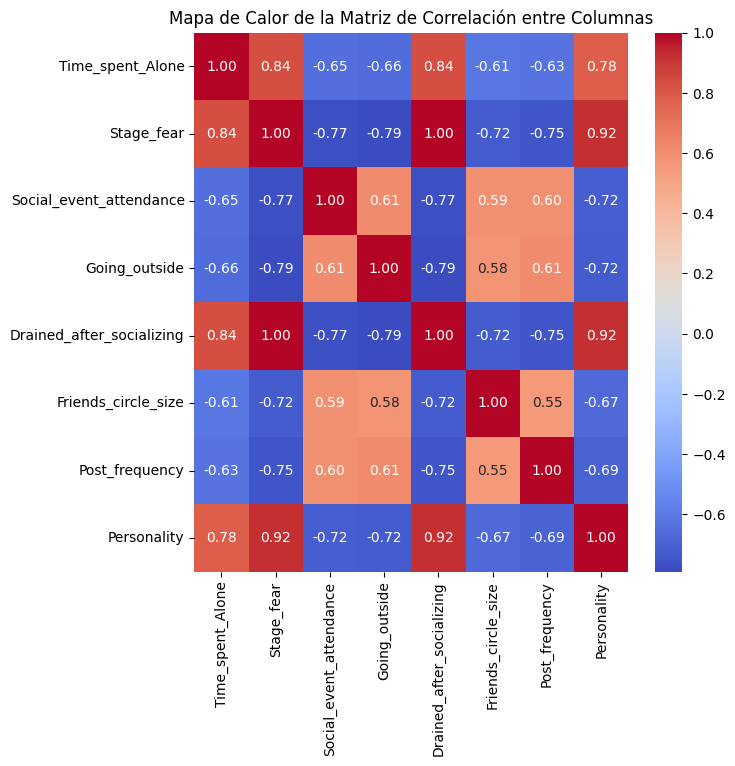

In [38]:
# Calcular la matriz de correlación
correlation_matrix = train_df_encoded.corr(numeric_only=True)

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(7, 7))  # Ajusta el tamaño de la figura según necesites
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor de la Matriz de Correlación entre Columnas')
plt.show()

In [39]:
# Sólo ejecutar hasta verificar 
train_df_encoded['Personality'] = train_df_encoded['Personality'].replace(0, 'Extrovert')
train_df_encoded['Personality'] = train_df_encoded['Personality'].replace(1, 'Introvert')
train_df_encoded['Stage_fear'] = train_df_encoded['Stage_fear'].replace(0, 'No')
train_df_encoded['Stage_fear'] = train_df_encoded['Stage_fear'].replace(1, 'Yes')
train_df_encoded['Drained_after_socializing'] = train_df_encoded['Drained_after_socializing'].replace(0, 'No')
train_df_encoded['Drained_after_socializing'] = train_df_encoded['Drained_after_socializing'].replace(1, 'Yes')

TypeError: Invalid value 'Extrovert' for dtype Int64

In [40]:
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Time_spent_Alone           18524 non-null  Int64
 1   Stage_fear                 18524 non-null  Int64
 2   Social_event_attendance    18524 non-null  Int64
 3   Going_outside              18524 non-null  Int64
 4   Drained_after_socializing  18524 non-null  Int64
 5   Friends_circle_size        18524 non-null  Int64
 6   Post_frequency             18524 non-null  Int64
 7   Personality                18524 non-null  Int64
dtypes: Int64(8)
memory usage: 1.3 MB


# Training and testing different models

## Using PCA

In [ ]:
columns = ['id']
train_df_useful = df_train_simple.drop(columns, axis=1)

In [ ]:
Y_train = train_df_useful["Personality"]
X_train = train_df_useful.drop(['Personality'], axis=1)

In [ ]:
le = LabelEncoder()
X_train['Stage_fear'] = le.fit_transform(X_train['Stage_fear'])
X_train['Drained_after_socializing'] = le.fit_transform(X_train['Drained_after_socializing'])

In [ ]:
X_train.shape

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_train.columns)

In [ ]:
pca = PCA(n_components=7)
principal_components = pca.fit_transform(X_scaled_df)

In [ ]:
## 4. Obtener la varianza explicada

# Varianza explicada por cada componente individual
explained_variance_ratio = pca.explained_variance_ratio_

# Varianza explicada acumulada
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [ ]:
## 5. Graficar la Varianza Explicada como un Gráfico de Barras

plt.figure(figsize=(10, 6))

# Gráfico de barras de la varianza explicada por cada componente
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio,
        alpha=0.8, color='skyblue')

plt.xlabel('Número de Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Gráfico de Barras de Varianza Explicada por Componente Principal (Scree Plot)')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7) # Grid solo en el eje Y para mayor claridad

plt.show()

# Opcional: También puedes superponer la varianza acumulada en el mismo gráfico
plt.figure(figsize=(10, 6))
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio,
        alpha=0.8, color='skyblue', label='Varianza Explicada Individual')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance,
         marker='x', linestyle='-', color='red', label='Varianza Explicada Acumulada')

plt.xlabel('Número de Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Gráfico de Barras y Línea de Varianza Explicada (Scree Plot)')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
# 1. Crear los nombres de las columnas para los componentes principales
# Por ejemplo, 'PC1', 'PC2', ..., 'PC_n'
n_components_to_keep = 7
pca_column_names = [f'PC{i+1}' for i in range(n_components_to_keep)]

# 2. Crear el DataFrame de pandas
# Es buena práctica mantener el mismo índice que el DataFrame original de la muestra
# para poder unirlo fácilmente si lo necesitas.
df_pca = pd.DataFrame(data=principal_components, columns=pca_column_names, index=df_train_simple.index)

print("\nDataFrame de PCA (primeras 5 filas):")
df_pca.head()

In [ ]:
columns = ['PC6','PC7']
df_pca_ = df_pca.drop(columns, axis=1)
df_pca_.head()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_pca_, Y_train, test_size=0.3, random_state=42)

### Catboost with PCA

In [ ]:
#Use Optuna to find the best hyperparameters
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=0,
        #cat_features=categorical_features_names,
        task_type='GPU'
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [ ]:
#Create the study
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [ ]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
Cat_Boost_Classifier_Tuned = catboost.CatBoostClassifier(
    **trial.params, 
    verbose=0, 
    task_type='GPU',
    #cat_features=categorical_features_names
)

In [ ]:
Cat_Boost_Classifier_Tuned.fit(x_train, y_train)

In [ ]:
Predict_Fertilizer_Name = Cat_Boost_Classifier_Tuned.predict(x_test)

## without PCA

In [41]:
columns = ['id']
train_df_useful = df_train.drop(columns, axis=1)

In [42]:
train_df_useful = train_df_encoded

In [43]:
Y_train = train_df_useful["Personality"]
X_train = train_df_useful.drop(['Personality'], axis=1)

In [ ]:
X_train.info()

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

## Catboost

In [ ]:
categorical_features_names = ['Stage_fear','Drained_after_socializing']

In [45]:
#Use Optuna to find the best hyperparameters
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=0,
        #cat_features=categorical_features_names,
        task_type='GPU'
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

In [46]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [47]:
#Create the study
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[W 2025-07-04 14:16:48,553] Trial 0 failed with parameters: {'iterations': 475, 'learning_rate': 0.027583475549166746, 'depth': 4, 'l2_leaf_reg': 1.0551779964424746e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0931628460945333e-07, 'bagging_temperature': 0.923385947687978, 'od_type': 'Iter', 'od_wait': 26} because of the following error: CatBoostError('catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_35/2532027738.py", line 17, in objective
    model.fit(x_train, y_train)
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, 

CatBoostError: catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
Cat_Boost_Classifier_Tuned = catboost.CatBoostClassifier(
    **trial.params, 
    verbose=0, 
    task_type='GPU',
    #cat_features=categorical_features_names
)

In [ ]:
Cat_Boost_Classifier_Tuned.fit(x_train, y_train)

In [ ]:
Predict_Fertilizer_Name = Cat_Boost_Classifier_Tuned.predict(x_test)

# Prediction and Submission

## with PCA

In [ ]:
df_test_simple = df_test.copy()

In [ ]:
options = ['Yes', 'No']
index_nan = df_test_simple[df_test_simple['Stage_fear'].isnull()].index
print(index_nan)
# Generar un array de elecciones aleatorias ('yes' o 'no') del mismo tamaño que los NaN
random_select = np.random.choice(options, size=len(index_nan))

# Asignar las elecciones aleatorias a los valores nulos
df_test.loc[index_nan, 'Stage_fear'] = random_select

print(df_test_simple['Stage_fear'].isnull().sum())
print(df_test_simple['Stage_fear'])

In [ ]:
index_nan_ = df_test_simple[df_test_simple['Drained_after_socializing'].isnull()].index
print(index_nan_ )
# Generar un array de elecciones aleatorias ('yes' o 'no') del mismo tamaño que los NaN
random_select = np.random.choice(options, size=len(index_nan_))

# Asignar las elecciones aleatorias a los valores nulos
df_test.loc[index_nan_, 'Drained_after_socializing'] = random_select

print(df_test_simple['Drained_after_socializing'].isnull().sum())
print(df_test_simple['Drained_after_socializing'])

In [ ]:
df_test_simple.fillna({'Time_spent_Alone': df_test_simple['Time_spent_Alone'].median()}, inplace=True)
print(df_test_simple['Time_spent_Alone'].isnull().sum())
df_test_simple.fillna({'Social_event_attendance': df_test_simple['Social_event_attendance'].median()}, inplace=True)
print(df_test_simple['Social_event_attendance'].isnull().sum())
df_test_simple.fillna({'Going_outside': df_test_simple['Going_outside'].median()}, inplace=True)
print(df_test_simple['Going_outside'].isnull().sum())
df_test_simple.fillna({'Friends_circle_size': df_test_simple['Friends_circle_size'].median()}, inplace=True)
print(df_test_simple['Friends_circle_size'].isnull().sum())
df_test_simple.fillna({'Post_frequency': df_test_simple['Post_frequency'].median()}, inplace=True)
print(df_test_simple['Post_frequency'].isnull().sum())

In [ ]:
df_test_simple.info()

In [ ]:
columns = ['id']
test_df_useful = df_test_simple.drop(columns, axis=1)

In [ ]:
le = LabelEncoder()
test_df_useful['Stage_fear'] = le.fit_transform(test_df_useful['Stage_fear'])
test_df_useful['Drained_after_socializing'] = le.fit_transform(test_df_useful['Drained_after_socializing'])

In [ ]:
scaler = StandardScaler()
X_scaled_useful = scaler.fit_transform(test_df_useful)
X_scaled_df_useful = pd.DataFrame(X_scaled_useful, columns=test_df_useful.columns)

In [ ]:
pca = PCA(n_components=7)
principal_components = pca.fit_transform(X_scaled_df_useful)

In [ ]:
# 1. Crear los nombres de las columnas para los componentes principales
# Por ejemplo, 'PC1', 'PC2', ..., 'PC_n'
n_components_to_keep = 7
pca_column_names = [f'PC{i+1}' for i in range(n_components_to_keep)]

# 2. Crear el DataFrame de pandas
# Es buena práctica mantener el mismo índice que el DataFrame original de la muestra
# para poder unirlo fácilmente si lo necesitas.
df_pca_test = pd.DataFrame(data=principal_components, columns=pca_column_names, index=df_test_simple.index)

print("\nDataFrame de PCA (primeras 5 filas):")
df_pca_test.head()

In [ ]:
columns = ['PC6','PC7']
df_pca_test_ = df_pca_test.drop(columns, axis=1)
df_pca_test_.head()

### Using Catboost Classifier

In [ ]:
prediction_Y=Cat_Boost_Classifier_Tuned.predict(df_pca_test_)

In [ ]:
prediction_df = df_test.assign(Personality=prediction_Y)
prediction_df.head()

In [ ]:
Submission = prediction_df[['id','Personality']]
Submission.head()

In [ ]:
Submission.to_csv('Prediction_Catboost_Classifier_with_PCA_0.csv', index=False)

## With KNN Imputer

In [ ]:
df_test_knn = df_test.copy()

In [ ]:
label_encoders = {}

# Aplica LabelEncoder a cada columna y guarda el encoder
for column in ['Stage_fear', 'Drained_after_socializing']:
    le = LabelEncoder()
    df_test_knn[column] = le.fit_transform(df_test_knn[column])
    label_encoders[column] = le

# Ahora, para ver la asignación de números a cada categoría:
print("Asignación para 'Stage_fear':")
for i, category in enumerate(label_encoders['Stage_fear'].classes_):
    print(f"'{category}': {i}")

print("\nAsignación para 'Drained_after_socializing':")
for i, category in enumerate(label_encoders['Drained_after_socializing'].classes_):
    print(f"'{category}': {i}")

print("\nAsignación para 'Personality':")
for i, category in enumerate(label_encoders['Personality'].classes_):
    print(f"'{category}': {i}")

In [ ]:
df_test_knn['Stage_fear'] = df_test_knn['Stage_fear'].replace(2, np.nan)
df_test_knn['Drained_after_socializing'] = df_test_knn['Drained_after_socializing'].replace(2, np.nan)

In [ ]:
columns = ['id']
test_df_useful = df_test_knn.drop(columns, axis=1)

In [ ]:
imputer = KNNImputer()
test_without_nan = imputer.fit_transform(test_df_useful)
test_without_nan

In [ ]:
# Crear el nuevo DataFrame directamente, ya que todas las columnas son numéricas
df_test_without_nan = pd.DataFrame(test_without_nan,
                                       columns=test_df_useful.columns, # Usa todas las columnas originales
                                       index=test_df_useful.index)

In [ ]:
for col_name in df_test_without_nan.columns: 
    df_test_without_nan[col_name]=df_test_without_nan[col_name].round()# 'col_name' es una cadena (ej. 'ID')
    df_test_without_nan[col_name] = df_test_without_nan[col_name].astype('Int64')

In [ ]:
test_df_useful[df_test_without_nan.columns] = df_test_without_nan
test_df_useful.info()

## Catboost

In [ ]:
prediction_Y=Cat_Boost_Classifier_Tuned.predict(test_df_useful)

In [ ]:
prediction_df = df_test.assign(Personality=prediction_Y)
prediction_df.head()

In [ ]:
Submission = prediction_df[['id','Personality']]
Submission.head()

In [ ]:
Submission['Personality'] = Submission['Personality'].replace(0, 'Extrovert')
Submission['Personality'] = df_train_knn['Personality'].replace(1, 'Introvert')

In [ ]:
Submission.to_csv('Prediction_Catboost_Classifier_0.csv', index=False)